# **Stratify Project : DECODING THE BASKET**

# **TASK 1 : EXPLORATORY DATA ANALYSIS**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading & Initial Inspection
**Library Imports**

numpy and pandas for data manipulation

matplotlib for later visualizations

**Load CSV Files**

orders → Order metadata (e.g., user IDs, evaluation set, days since prior order)

op_prior → Products from users’ previous orders

op_train → Products from the training set of orders

products → Product catalog with aisle and department references

aisles → List of aisle IDs and names

departments → List of department IDs and names

**Handle Missing Values**

All NaN values in the orders DataFrame are replaced with 0 to ensure consistency during analysis.

**Quick Checks for Each Dataset**

Display shape (rows × columns)

Display missing values count per column

Preview the first 10 rows to understand the format and sample values

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Load CSVs
orders       = pd.read_csv("/content/drive/MyDrive/order_metadata.csv")
op_prior     = pd.read_csv("/content/drive/MyDrive/order_items__prior.csv")
op_train     = pd.read_csv("/content/drive/MyDrive/order_items__train.csv")
products     = pd.read_csv("/content/drive/MyDrive/product_catalog.csv")
aisles       = pd.read_csv("/content/drive/MyDrive/aisle_info.csv")
departments  = pd.read_csv("/content/drive/MyDrive/department_info.csv")

# Replacing NaN with 0 in orders (After the verification via running this step beforehand)
orders = orders.fillna(0)  # this creates a new DataFrame with NaNs replaced by 0

# Creating folder to store outputs
os.makedirs("eda_outputs", exist_ok=True)

#Cleaned DataFrames saving in folder
orders.to_csv("eda_outputs/orders_cleaned.csv", index=False)
op_prior.to_csv("eda_outputs/order_products_prior.csv", index=False)
op_train.to_csv("eda_outputs/order_products_train.csv", index=False)
products.to_csv("eda_outputs/products.csv", index=False)
aisles.to_csv("eda_outputs/aisles.csv", index=False)
departments.to_csv("eda_outputs/departments.csv", index=False)


# Quick checks for each dataframes
print("\nOrders:")
print("Shape:", orders.shape)
print("Missing values:\n", orders.isna().sum())
print(orders.head(10))

print("\nOrder Products (Prior):")
print("Shape:", op_prior.shape)
print("Missing values:\n", op_prior.isna().sum())
print(op_prior.head(10))

print("\nOrder Products (Train):")
print("Shape:", op_train.shape)
print("Missing values:\n", op_train.isna().sum())
print(op_train.head(10))

print("\nProducts:")
print("Shape:", products.shape)
print("Missing values:\n", products.isna().sum())
print(products.head(10))

print("\nAisles:")
print("Shape:", aisles.shape)
print("Missing values:\n", aisles.isna().sum())
print(aisles.head(10))

print("\nDepartments:")
print("Shape:", departments.shape)
print("Missing values:\n", departments.isna().sum())
print(departments.head(10))



Orders:
Shape: (3421083, 7)
Missing values:
 order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   
5   3367565        1    prior             6          2                  7   
6    550135        1    prior             7          1                  9   
7   3108588        1    prior             8          1                 14   
8   2295261        1    prior             9         

# Total Orders & Unique Customers
The first step in our exploratory data analysis is to understand the overall scale of FreshMart's online orders.  
We calculate:
- **Total number of orders**: Gives us the complete order volume in the dataset.
- **Unique customers**: Indicates the customer base size, useful for estimating market penetration and customer retention.

These metrics provide a quick snapshot of the platform's activity and user engagement levels.


In [3]:
#Total orders & unique customers
total_orders = orders["order_id"].nunique()
unique_customers = orders["user_id"].nunique()

print(f"Total orders: {total_orders}")
print(f"Unique customers: {unique_customers}")

# Saving text output
with open("eda_outputs/totals.txt", "w") as f:
    f.write(f"Total orders: {total_orders}\nUnique customers: {unique_customers}")


Total orders: 3421083
Unique customers: 206209


# Unique Products, Aisles, and Departments
To better understand the diversity of FreshMart’s catalog,  
We calculate the number of:
- **Unique products**: Indicates the total variety available to customers.
- **Unique aisles**: Reflects the range of product groupings within the store.
- **Unique departments**: Represents higher-level product categories.

These counts help us assess the breadth of FreshMart's offerings,  
which can influence inventory management and recommendation strategies.

In [4]:
# Count total number of unique products,aisles and departments
n_products = products["product_id"].nunique()
n_aisles = aisles["aisle_id"].nunique()
n_departments = departments["department_id"].nunique()

print(f"Unique products: {n_products}")
print(f"Unique aisles: {n_aisles}")
print(f"Unique departments: {n_departments}")

#saving this data in text file
with open("eda_outputs/uniques.txt", "w") as f:
    f.write(f"Products: {n_products}\nAisles: {n_aisles}\nDepartments: {n_departments}")


Unique products: 49688
Unique aisles: 134
Unique departments: 21


# Top 20 Most Ordered Products
Understanding which products are most frequently purchased  
provides insights into customer preferences and core demand drivers.  
This information can be used to:
- Ensure consistent stock availability of high-demand items.
- Strategically position these products in promotional campaigns.
- Use them as anchor items in product bundles to drive additional sales.

We identify the top 20 products by counting the total number of times  
each product has been ordered (across all customers and orders).

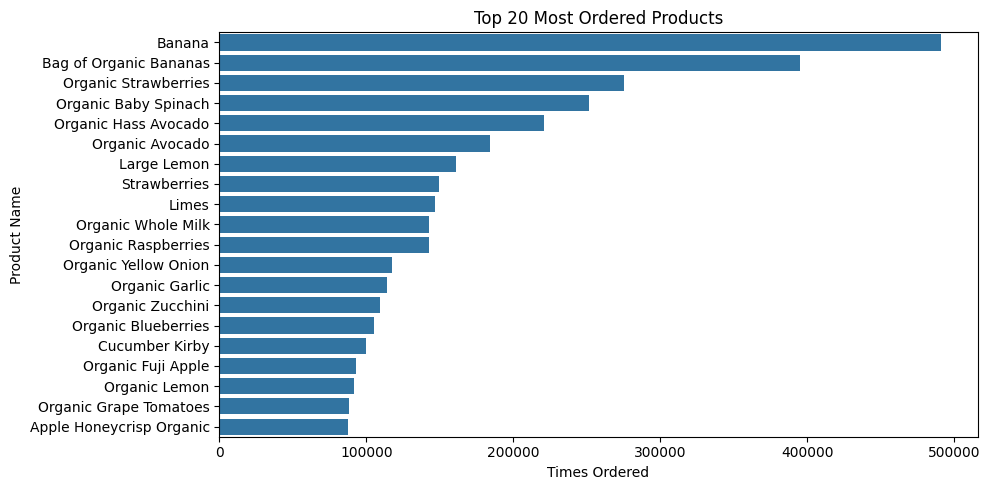

In [5]:
import seaborn as sns

# Combine prior and train order datasets into one DataFrame for complete order history
order_products = pd.concat([op_prior, op_train], ignore_index=True)

# Calculate the number of times each product has been ordered
top_products = (order_products
    .groupby("product_id")["order_id"].count().reset_index(name="times_ordered")# Rename count column
    .merge(products[["product_id", "product_name"]], on="product_id", how="left")# Add product names
    .sort_values("times_ordered", ascending=False)# Sort
    .head(20)
)

# Ensure plots directory exists
os.makedirs("plots", exist_ok=True)

# Barplot for top products
plt.figure(figsize=(10,5))
sns.barplot(data=top_products, x="times_ordered", y="product_name")
plt.title("Top 20 Most Ordered Products")
plt.xlabel("Times Ordered")
plt.ylabel("Product Name")
plt.tight_layout()
plt.savefig("plots/top_products.png", dpi=300)#save plot
plt.show()


# Departments & Aisles by Orders
Analyzing orders by department and aisle reveals which product  
categories dominate customer purchases.  

Key insights from this analysis:
- High-order departments often represent staple items (e.g., produce, dairy).
- Understanding top aisles helps optimize product placement and cross-selling.
- Identifies niche but consistently purchased categories.

We:
1. Enriched product data by merging it with aisle and department metadata.
2. Counted total orders for each department and aisle.
3. Visualized the top departments and top 20 aisles by number of orders.


/tmp/ipython-input-2534090133.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dept_counts, x="orders", y="department", palette="mako")


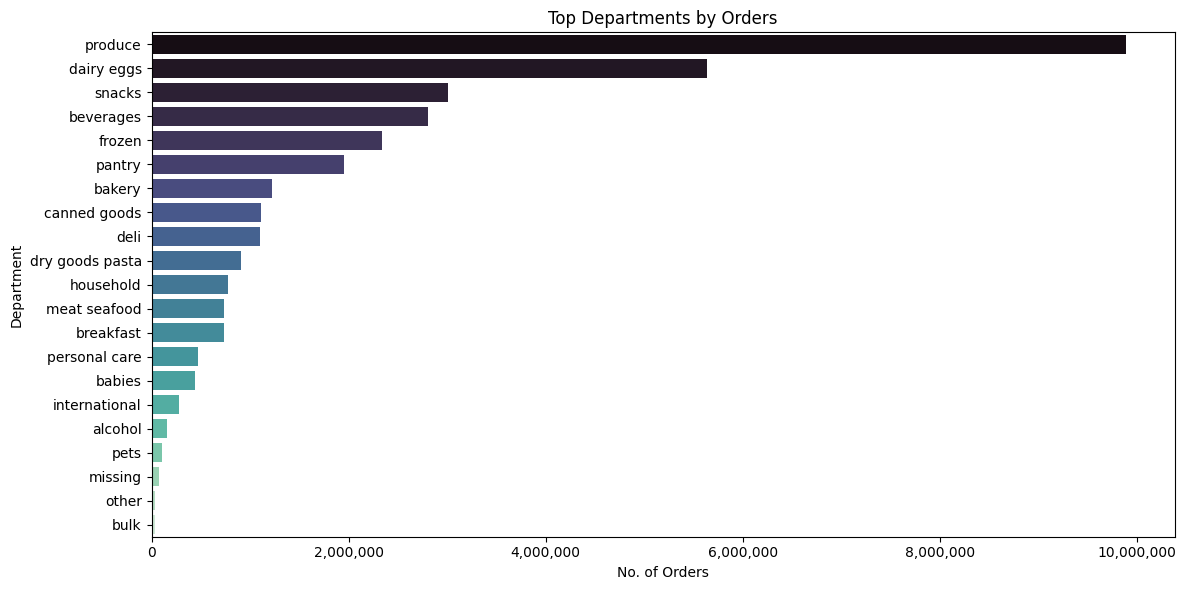

/tmp/ipython-input-2534090133.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=aisle_counts, x="orders", y="aisle", palette="mako")


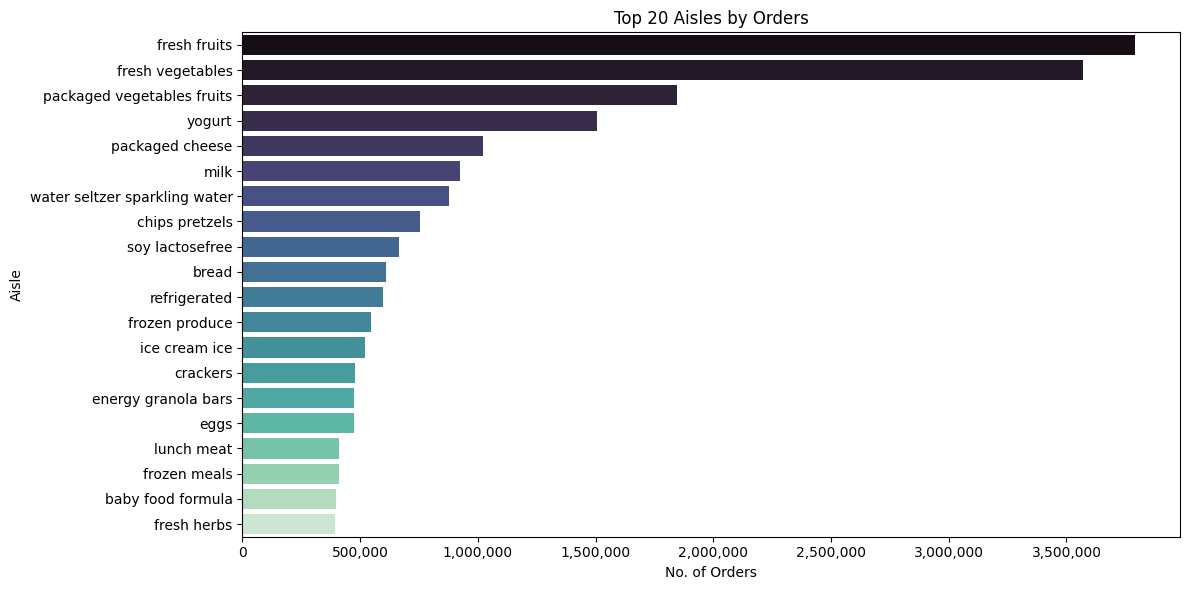

In [6]:
# Merge products with aisle and department information
products_full = (products
                 .merge(aisles, on="aisle_id", how="left")
                 .merge(departments, on="department_id", how="left"))

# Enrich order_products with department and aisle details
op_enriched = order_products.merge(products_full, on="product_id", how="left")


# Departments by orders
dept_counts = (op_enriched.groupby("department")["order_id"].count()
               .reset_index(name="orders")
               .sort_values("orders", ascending=False))


import matplotlib.ticker as mtick
plt.figure(figsize=(12,6))
sns.barplot(data=dept_counts, x="orders", y="department", palette="mako")
plt.title("Top Departments by Orders")
plt.xlabel("No. of Orders")
plt.ylabel("Department")

# Force plain numbers instead of scientific notation
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.savefig("plots/top_departments.png", dpi=300)#save plot
plt.show()

# Aisles by orders
aisle_counts = (op_enriched.groupby("aisle")["order_id"].count()
                .reset_index(name="orders")
                .sort_values("orders", ascending=False)
                .head(20))

plt.figure(figsize=(12,6))
sns.barplot(data=aisle_counts, x="orders", y="aisle", palette="mako")
plt.title("Top 20 Aisles by Orders")
plt.xlabel("No. of Orders")
plt.ylabel("Aisle")

# Force plain numbers instead of scientific notation
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.savefig("plots/top_aisles.png", dpi=300)#save plot
plt.show()


# Most Reordered Products
Reorder rate measures the proportion of orders for a product that  
come from repeat purchases.  

Insights from this analysis:
- High reorder rates indicate products that customers buy frequently,  
  suggesting they are essential or highly preferred.
- Filtering products with at least 100 orders helps remove noise from  
  rarely purchased items with artificially high reorder rates.
- Identifying these products helps in targeted promotions and stock  
  replenishment strategies.

We:
1. Calculated the total orders ("n_orders) and mean reorder rate for each product.
2. Filtered out products with fewer than 100 orders for reliability.
3. Displayed the top 20 products ranked by reorder rate.


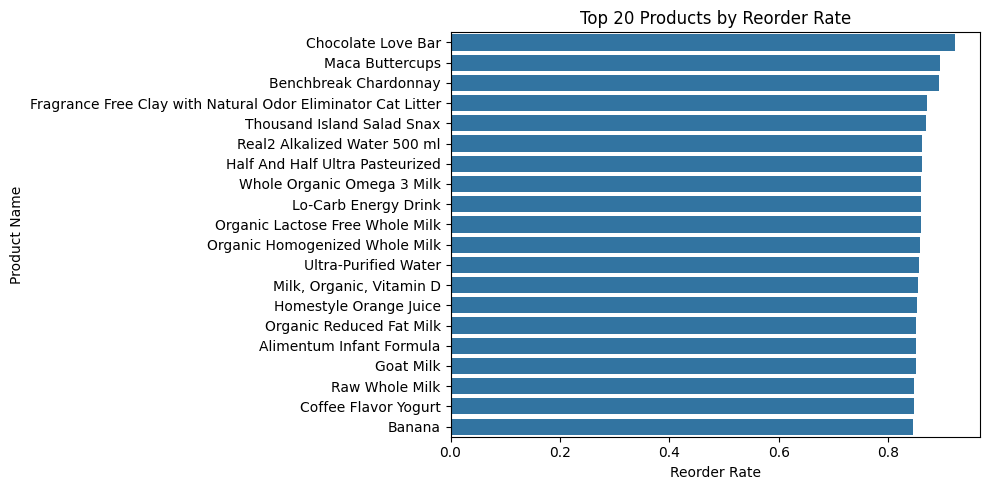

In [7]:
# Calculate number of orders and reorder rate for each product
prod_reorder = (order_products.groupby("product_id")
                .agg(n_orders=("order_id", "count"), reorder_rate=("reordered", "mean"))# total orders for the product and proportion of times product was reordered
                .reset_index()
                .merge(products[["product_id", "product_name"]], on="product_id", how="left"))

# Filter to only include products with at least 100 orders
prod_reorder = prod_reorder[prod_reorder["n_orders"] >= 100]

# Sort by reorder rate and select top 20
most_reordered = prod_reorder.sort_values("reorder_rate", ascending=False).head(20)

plt.figure(figsize=(10,5))
sns.barplot(data=most_reordered, x="reorder_rate", y="product_name")
plt.title("Top 20 Products by Reorder Rate")
plt.xlabel("Reorder Rate")
plt.ylabel("Product Name")
plt.tight_layout()
plt.savefig("plots/most_reordered_products.png", dpi=300)
plt.show()


# Basket Size Analysis
The basket size refers to the number of products in a single order.  
This analysis helps understand typical shopping patterns:

- **Mean basket size**: Provides the average number of products purchased per order.
- **Histogram**: Shows the distribution of basket sizes, focusing on orders with ≤ 50 items for better visibility.
- **Boxplot**: Highlights the spread of basket sizes and presence of outliers.


Average basket size: 10.11


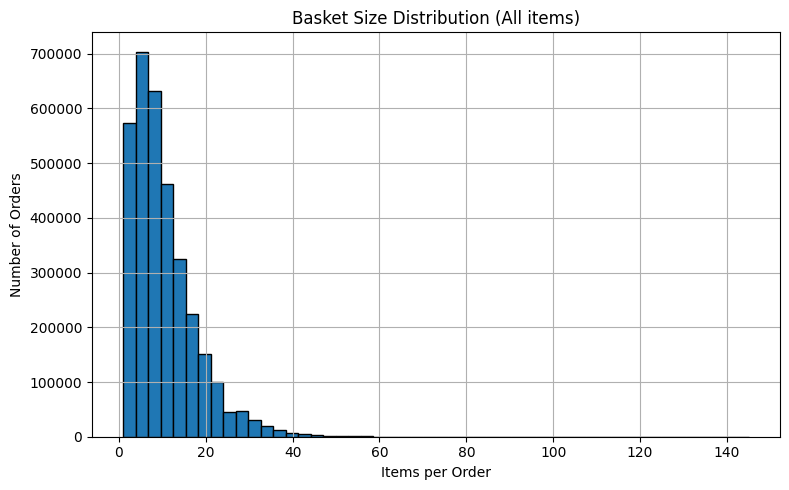

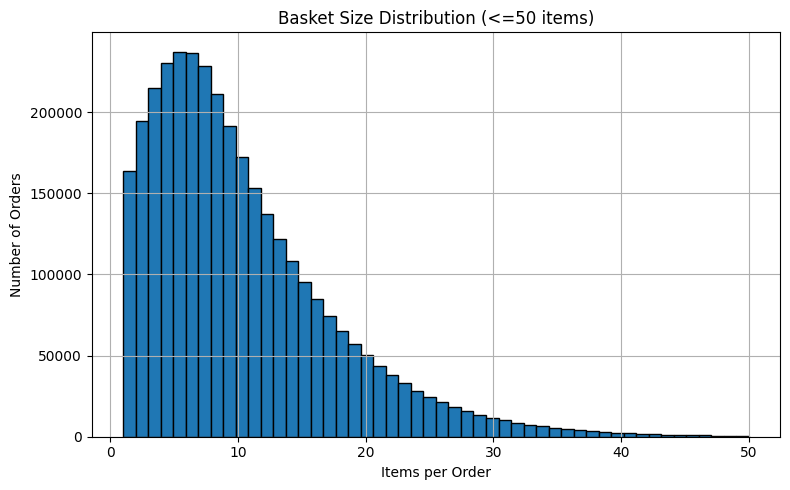

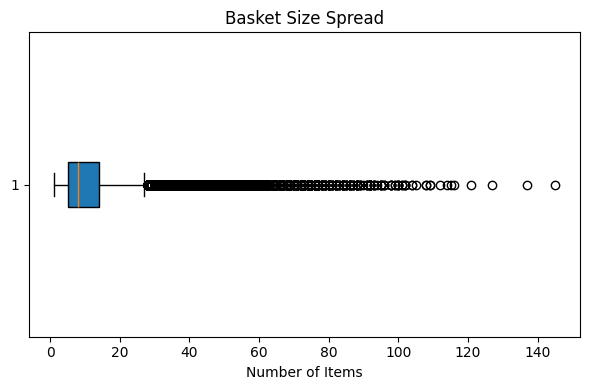

In [8]:
# Group by order_id and count how many products in each order
basket_sizes = order_products.groupby("order_id")["product_id"].count()

# Calculate average basket size across all orders
avg_basket_size = basket_sizes.mean()
print(f"Average basket size: {avg_basket_size:.2f}")

plt.figure(figsize=(8, 5))
basket_sizes.hist(bins=50, edgecolor='black')
plt.title("Basket Size Distribution (All items)")
plt.xlabel("Items per Order")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.savefig("plots/basket_size_hist.png", dpi=300)
plt.show()

#A new plot where restrict to baskets ≤ 50 items for better plot readability
plt.figure(figsize=(8, 5))
basket_sizes[basket_sizes <= 50].hist(bins=50, edgecolor='black')
plt.title("Basket Size Distribution (<=50 items)")
plt.xlabel("Items per Order")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.savefig("plots/basket_size_lessthan50_hist.png", dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
plt.boxplot(basket_sizes, vert=False, patch_artist=True)# Boxplot shows distribution, median, and outliers
plt.title("Basket Size Spread")
plt.xlabel("Number of Items")
plt.tight_layout()
plt.savefig("plots/basket_size_box.png", dpi=300)
plt.show()


# Order Trends
This analysis examines when customers place their orders, helping identify peak shopping times and repeat purchase patterns.


**Hour of Day:**

Shows how many orders are placed during each hour (0–23).

Helps detect the most active hours for shopping.



**Day of Week:**

Displays order counts for each day (0 = Sunday, 6 = Saturday).

Useful for spotting weekly demand cycles.

**Days Since Prior Order:**

Shows the distribution of the gap (in days) between consecutive orders.

Helps understand customer reorder frequency and engagement habits.

/tmp/ipython-input-2459738318.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=orders_by_hour.index, y=orders_by_hour.values, palette="crest")


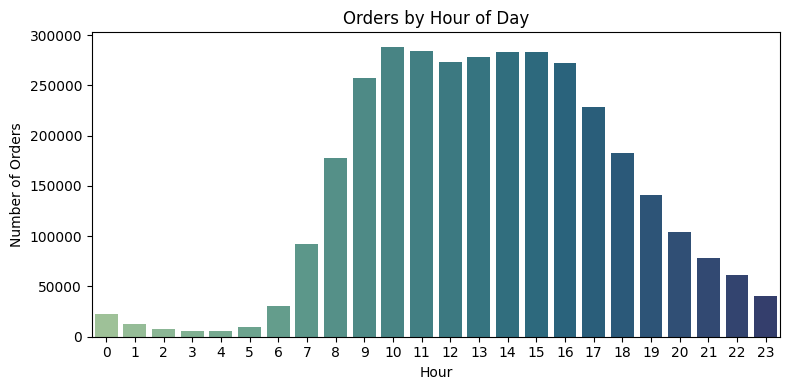

/tmp/ipython-input-2459738318.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=orders_by_dow.index, y=orders_by_dow.values, palette="crest")


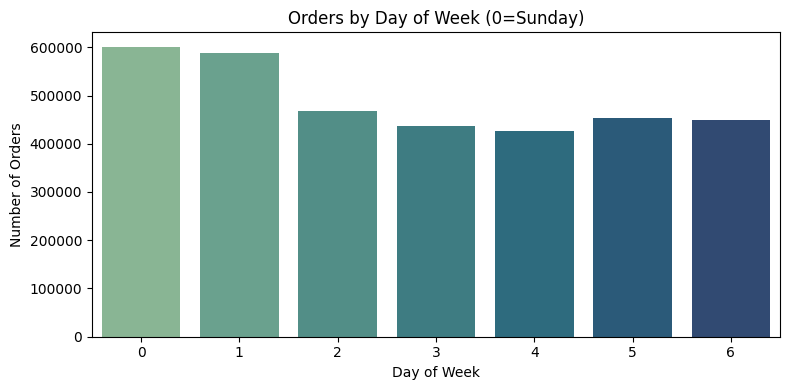

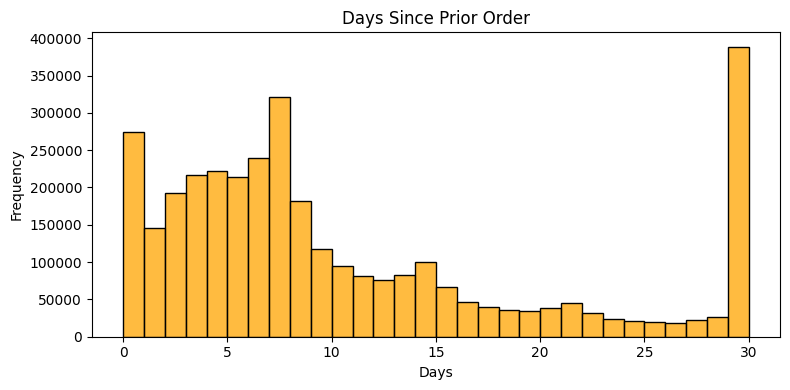

In [9]:
# Hour of day

# Count number of orders for each hour (0–23), sort in chronological order
orders_by_hour = orders["order_hour_of_day"].value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.barplot(x=orders_by_hour.index, y=orders_by_hour.values, palette="crest")
plt.title("Orders by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.savefig("plots/hourly_orders.png", dpi=300)
plt.show()

# Day of week


#Count orders for each day of week (0=Sunday, 6=Saturday), sorted by day number
orders_by_dow = orders["order_dow"].value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.barplot(x=orders_by_dow.index, y=orders_by_dow.values, palette="crest")
plt.title("Orders by Day of Week (0=Sunday)")
plt.xlabel("Day of Week")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.savefig("plots/day_wise_orders.png", dpi=300)
plt.show()

# Days since prior order
plt.figure(figsize=(8,4))
# Histogram of how many days passed between consecutive orders
sns.histplot(orders["days_since_prior_order"], bins=30, kde=False, color="orange")
plt.title("Days Since Prior Order")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("plots/days_since_prior_orders.png", dpi=300)
plt.show()
